In [75]:
import os, sys
os.chdir('/home/koritskiy/rqc/hamiltonian_learning')
from random import seed
from modules.main import *
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
np.set_printoptions(suppress=True)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
def to_basis(angles):
    v = np.cos(angles[0] / 2)
    w = np.sin(angles[0] / 2) * np.exp(1j*angles[1])
    b = np.array([v, w]).reshape(2, 1)
    
    return b @ b.T.conj()

In [77]:
def double_plot(Y1, Y2, Y1_name=None, Y2_name=None):

    X = range(len(Y1))
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('iterations')
    if Y1_name:
        ax1.set_ylabel(Y1_name, color=color)
    else:
        ax1.set_ylabel("Y1", color=color)
    ax1.scatter(X, Y1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    if Y1_name:
        ax2.set_ylabel(Y2_name, color=color)
    else:
        ax2.set_ylabel("Y2", color=color)  # we've already handled the x-label with ax1
    ax2.scatter(X, Y2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    plt.show()

In [78]:
def num_der(angles):
    
    d_angles = angles * 10 ** - 4
    grad  = np.zeros((n_spins, 2))
    for s in range(n_spins):
        for a in range(2):
            new_angles = np.copy(angles)
            new_angles[s, a] += d_angles[s, a]

            s_t, c_t = hamiltonian_t.measure(angles)
            s_g, c_g = hamiltonian_g.measure(angles)
            distance = distance_by_measurements(s_t, s_g, c_t, c_g)

            d_s_t, d_c_t = hamiltonian_t.measure(new_angles)
            d_s_g, d_c_g = hamiltonian_g.measure(new_angles)
            d_distance = distance_by_measurements(d_s_t, d_s_g, d_c_t, d_c_g)

            grad[s, a] = (d_distance - distance) / d_angles[s, a]
    return grad

In [89]:
# Some initial parameters
# np.random.seed(40)
# seed(40)

eps = 10 ** -2

n_spins = 2
beta = 0.3
cycles = 100

lr = 0.3
gradient_iterations = 1

"""Random inintial angles"""
# Create initial random basis angles
theta = np.random.rand(n_spins) * np.pi
phi = np.random.rand(n_spins) * 2 * np.pi

angles_0 = np.array([theta, phi]).T
print(angles_0)
"""Specific initial angles"""
# angles_0 = np.array([[np.pi/2, 0], [np.pi/2, 0]]) 
# angles_0 = np.array([[np.pi/2, 0], [1.58449883, 0]]) 
# angles_0 = np.array([[np.pi/2, 0]]) 


"""Fields and couplings"""
xx_t = [1]
yy_t = [-1]
# z_t = [-1, -1]
# x_t = [-1, -1]

xx_g = [-1]
yy_g = [1]
# z_g = [-1, -1]
# x_g = [1, 1]


# z_t = [-1]
# x_t = [-1]
# z_g = [-1]
# x_g = [1]


"""Initiate hamiltonians"""
# hamiltonian_t = Hamiltonian(n_spins, beta, z=z_t, x=x_t, xx=xx_t, yy=yy_t)
hamiltonian_t = Hamiltonian(n_spins, beta, xx=xx_t, yy=yy_t)
# hamiltonian_t = Hamiltonian(n_spins, beta, x=x_t, z=z_t)
hamiltonian_t.set_density_mat()

# hamiltonian_g = Hamiltonian(n_spins, beta, z=z_g, x=x_g, xx=xx_g, yy=yy_g)
hamiltonian_g = Hamiltonian(n_spins, beta, xx=xx_g, yy=yy_g)
# hamiltonian_g = Hamiltonian(n_spins, beta, x=x_g, z=z_g)
hamiltonian_g.set_density_mat();
# print(hamiltonian_t.density_mat)
# print(hamiltonian_g.density_mat)

[[0.79928754 5.44531401]
 [0.1787093  1.38876614]]


In [23]:
"""For singles"""
S = hamiltonian_t.density_mat
s = ReducedMatrixMeasurement.reduced_matrix(S, 0, 0)

print('Manual gradient')
print(f'A:{1/2-s[0, 0]}')
print(f'B:{np.real(s[0, 1]* np.exp(1j * angles_0[0,1]))}')
print(f'С:{-np.imag(s[0, 1] * np.exp(1j * angles_0[0,1]))}')

Manual gradient
A:0j
B:0.0
С:-0.0


In [106]:
D = hamiltonian_t.density_mat
# basis0 = to_basis(angles_0[0])
Id = np.eye(2)
basis1 = to_basis(angles_0[1])
basis = np.kron(Id, basis1)
D = D @ basis
d = ReducedMatrixMeasurement.reduced_matrix(D, 0, 0)

# corr = []
# for i in range(2):
#     for j in range(2):
#         basis_0 = to_basis(angles_0[0] + np.array([i * np.pi, 0]))
#         basis_1 = to_basis(angles_0[1] + np.array([j * np.pi, 0]))
#         basis = np.kron(basis_0, basis_1)
#         corr.append(np.real(np.trace(D @ basis)))
# print(corr)
A = 1/2-d[0, 0]
B = np.real(d[0, 1] * np.exp(1j * angles_0[0,1]))
C = np.imag(d[0, 1] * np.exp(1j * angles_0[0,1]))
print('Manual grad')
print(f'A:{1/2-d[0, 0]}')
print(f'B:{B}')
print(f'С:{C}')

Manual grad
A:(0.22912212377051444+0j)
B:-0.011030639144731638
С:-0.00677653082960234


In [25]:
angles_r = np.copy(angles_0)
angles_r[0] = np.array([0,0])
D = hamiltonian_t.rotation(angles_r)

b = to_spin(np.array([0,0]))
basis = b @ b.T.conj()
Id = np.eye(2)
basis = np.kron(Id, basis)
D = D @ basis
d = ReducedMatrixMeasurement.reduced_matrix(D, 0, 0)
print(d)
print(np.trace(d))
print('Manual grad')
print(f'A:{1/2-d[0, 0]}')
print(f'B:{np.real(d[0, 1] * np.exp(1j * angles_0[0,1]))}')
print(f'С:{np.imag(d[0, 1] * np.exp(1j * angles_0[0,1]))}')

NameError: name 'to_spin' is not defined

In [91]:
"""Analytical gradient"""

angles = np.copy(angles_0)
X = np.linspace(1, cycles, cycles)
Angles = np.zeros((cycles, n_spins, 2))
Distance = np.zeros(cycles)

# Angles[0] = angles
# singles_t, correlators_t = hamiltonian_t.measure(angles)
# singles_g, correlators_g = hamiltonian_g.measure(angles)

# Distance[0] = distance_by_measurements(singles_t, singles_g, correlators_t, correlators_g)
print('Analytical gradient')
for i in tqdm(range(cycles)):
    grad = Gradient(hamiltonian_t, hamiltonian_g, angles)
    angles = grad.gradient_descent(lr=lr, num_iterations=gradient_iterations)
#     angles += lr * num_der(angles)
    singles_t, correlators_t = hamiltonian_t.measure(angles)
    singles_g, correlators_g = hamiltonian_g.measure(angles)

#     print(f"singles_t {singles_t}")
#     print(f"singles_g {singles_g}")
    distance = distance_by_measurements(singles_t, singles_g, correlators_t, correlators_g)

    Angles[i] = angles
    Distance[i] = distance


Analytical gradient


[0.79928754 0.1787093 ]
A = [-0.02578836  0.        ]
B = [-0.36454992  0.        ]
C = [-0.24322347  0.        ]

[0.79928754 0.1787093 ]
A = [0.         0.18678658]
B = [ 0.         -0.33494216]
C = [ 0.         -0.22267197]

[0.79928754 0.1787093 ]
A = [0.0159674 0.       ]
B = [-0.34248865  0.        ]
C = [-0.25677653  0.        ]

[0.79928754 0.1787093 ]
A = [0.        0.2163706]
B = [ 0.        -0.2459746]
C = [ 0.         -0.27732804]

[0.79928754 0.1787093 ]
A = [0.0159674 0.       ]
B = [-0.34248865  0.        ]
C = [-0.25677653  0.        ]

[0.79928754 0.1787093 ]
A = [0.        0.2163706]
B = [ 0.        -0.2459746]
C = [ 0.         -0.27732805]

[0.79928754 0.1787093 ]
A = [-0.02578836  0.        ]
B = [-0.36454993  0.        ]
C = [-0.24322347  0.        ]

[0.79928754 0.1787093 ]
A = [0.         0.18678658]
B = [ 0.         -0.33494216]
C = [ 0.         -0.22267197]

[0.79928754 0.1787093 ]
A = [-0.02578836  0.        ]
B = [-0.34248864  0.        ]
C = [-0.25677653  0.

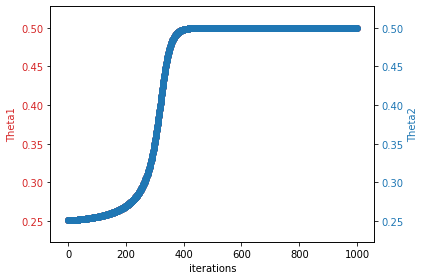

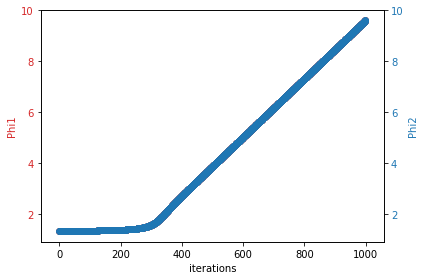

0.021215760324221566


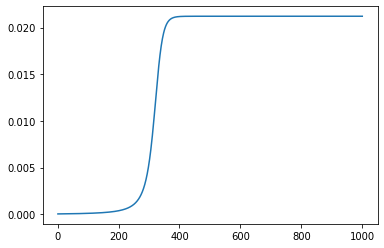

In [80]:
P_angles = Angles / np.pi  # Angles for drawing
double_plot(P_angles[:, 0, 0], P_angles[:, 0, 0], "Theta1", "Theta2")
double_plot(P_angles[:, 0, 1], P_angles[:, 0, 1], "Phi1", "Phi2")
plt.plot(X, Distance)
print(Distance[-1])

In [76]:
"""Numerical gradient"""
angles = np.copy(angles_0)
X = np.linspace(1, cycles, cycles)
Angles = np.zeros((cycles, n_spins, 2))
Distance = np.zeros(cycles)

Angles[0] = angles
singles_t, correlators_t = hamiltonian_t.measure(angles)
singles_g, correlators_g = hamiltonian_g.measure(angles)

Distance[0] = distance_by_measurements(singles_t, singles_g, correlators_t, correlators_g)
print('Numerical')
for i in tqdm(range(1, cycles)):
#     grad = Gradient(hamiltonian_t, hamiltonian_g, angles)
#     angles = grad.gradient_descent(lr=lr, num_iterations=gradient_iterations)
    grad_step = lr * num_der(angles) *10
    angles += grad_step
    print(num_der(angles))
    singles_t, correlators_t = hamiltonian_t.measure(angles)
    singles_g, correlators_g = hamiltonian_g.measure(angles)


    distance = distance_by_measurements(singles_t, singles_g, correlators_t, correlators_g)
    
    Angles[i] = angles
    Distance[i] = distance



Numerical


[[ 0.0000748   0.00008438]
 [ 0.00051036 -0.00008437]]
[[ 0.00007642  0.00008622]
 [ 0.00051617 -0.00008612]]
[[ 0.00007806  0.0000881 ]
 [ 0.0005222  -0.00008809]]
[[ 0.00007975  0.00009003]
 [ 0.00052861 -0.00009011]]
[[ 0.00008151  0.000092  ]
 [ 0.00053439 -0.000092  ]]
[[ 0.00008336  0.00009403]
 [ 0.0005412  -0.00009396]]
[[ 0.00008523  0.0000961 ]
 [ 0.00054764 -0.0000961 ]]
[[ 0.00008711  0.00009822]
 [ 0.00055428 -0.0000983 ]]
[[ 0.00008905  0.00010038]
 [ 0.0005608  -0.00010039]]
[[ 0.00009103  0.00010262]
 [ 0.00056764 -0.00010253]]
[[ 0.00009311  0.00010488]
 [ 0.00057426 -0.00010507]]
[[ 0.00009522  0.00010724]
 [ 0.0005814  -0.00010722]]
[[ 0.00009739  0.00010962]
 [ 0.00058841 -0.00010949]]
[[ 0.00009948  0.00011207]
 [ 0.00059585 -0.00011227]]
[[ 0.00010187  0.0001146 ]
 [ 0.00060357 -0.00011452]]
[[ 0.0001042   0.00011717]
 [ 0.00061064 -0.00011706]]
[[ 0.00010651  0.00011981]
 [ 0.00061845 -0.00011982]]
[[ 0.00010902  0.00012251]
 [ 0.00062605 -0.00012261]]
[[ 0.00011

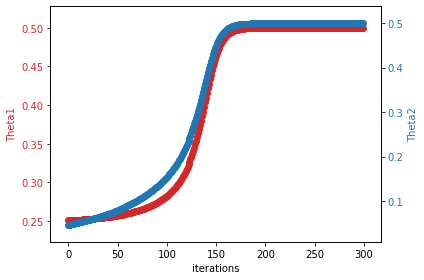

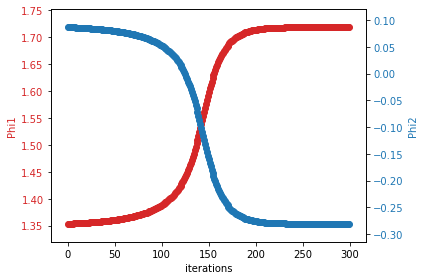

0.021215759341461443

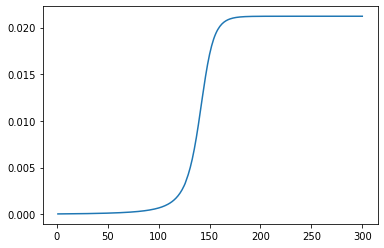

In [77]:
P_angles = Angles / np.pi  # Angles for drawing
double_plot(P_angles[:, 0, 0], P_angles[:, 1, 0], "Theta1", "Theta2")
double_plot(P_angles[:, 0, 1], P_angles[:, 1, 1], "Phi1", "Phi2")
plt.plot(X, Distance)
Distance[-1]

In [94]:
angles = Angles[-1]
# angles = np.array([[np.pi/2, 0],[np.pi/2, 0]])

singles_t, correlators_t = hamiltonian_t.measure(angles)
singles_g, correlators_g = hamiltonian_g.measure(angles)

distance = distance_by_measurements(singles_t, singles_g, correlators_t, correlators_g)
print(distance)

0.13121936184949443


In [46]:
Angles[-1]

array([[ 1.58449883, -0.        ],
       [ 1.58449883, -0.        ]])